# Spectral Coeficient Analysis for Recommendation Systems

### TEAM MEMBERS: Sri Satya Hamsika Pathuri​, Samrat Das Talukder and Srikar Giridhar

## ABSTRACT:
### Music streaming services have grown popular in the last decade. It is now easier than ever to listen to music regardless of where we are; however, finding music that suits our taste still seems to be quite a challenge.​
### While popular music streaming platforms generate recommended playlists, the use of collaborative filtering and/or hybrid filtering creates a bias and shifts away from the music itself.​ We aim to tackle that problem and make recommendations based on the spectral features of the songs.

## SCOPE OF THIS PROJECT:
### The scope of this project will be limited to the classification of the songs into various genres base on the said features.

## DATA SOURCE:
### GTZAN Dataset - Music Genre Classification (https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification)

### PACKAGES TO INSTALL BEFORE EXECUTION:
#### numpy
#### sys
#### librosa
#### matplotlib
#### soundfile
#### json
#### os
#### math
#### sklearn
#### tensorflow

In [1]:
# libraries
import numpy as np 
import sys
import librosa , librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
sys.path.append('D:/SRH Subjects/Sem 2/Technology Project 2/Trial1.wav') # path for the interpreter to use

## Basic flow for generating the waveform for a sample file
#### Numpy - Designed to manipulate multi dimensional matrix or arrays and mathematical functionals operating on arrays.
#### Librosa - Used to analyze audio signals. It is used for building a Music Intformation Retrieval system.
#### Matplot - Used for plotting and visualizing data in a graphical form.
#### sys.path.append - It gives to the access to the variables and the functions to interact strongly with the interpretors.

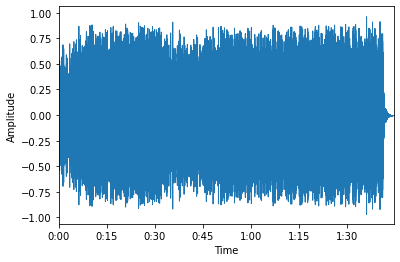

In [2]:
file = 'D:/SRH Subjects/Sem 2/Technology Project 2/Trial1.wav'
signal , sr = librosa.load(file , sr = 22050) # n_samples = 2.6 * 60 * 22050
librosa.display.waveplot(signal , sr = sr)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## FFT
#### Fast Fourier Transform to convert the signal we generated into individual spectral components. These spectral components form the basis from which frequency information about the signal can be found
#### We load the data set and and assign the sample rate for the audio. After that, we label the x, y axis and plot a wave graph for the same. By default, the audio is set in mono tone and resampled to 22050 Hz at load time.

In [3]:
fft = np.fft.fft(signal) 
fft # there are complex numbers in fft array so we should extract the magnitudes

array([-20.66329537-2.48689958e-14j, -36.81369073+1.43079559e+01j,
         1.01849393-3.26170697e-01j, ..., -18.73858966+3.77285390e+01j,
         1.01849393+3.26170697e-01j, -36.81369073-1.43079559e+01j])

#### The magnitude of the signal is extracted from the form of complex numbers. These magnitudes represent the contribution of each frequency within the sound.

In [4]:
mag = np.abs(fft)
mag

array([20.66329537, 39.49639766,  1.06944715, ..., 42.1257332 ,
        1.06944715, 39.49639766])

#### A numeric sequence of the above values are created here using np.linspace(). It creates a sequence of evenly spaced numbers structured as an numpy array.

In [5]:
freq = np.linspace(0 , sr , len(mag))
freq

array([0.00000000e+00, 9.54712839e-03, 1.90942568e-02, ...,
       2.20499809e+04, 2.20499905e+04, 2.20500000e+04])

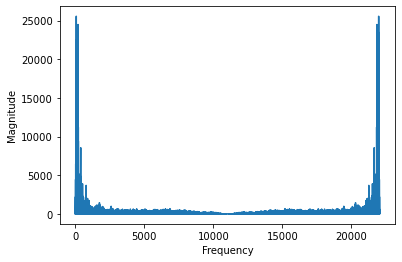

In [6]:
plt.plot(freq,mag)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

## STFT
#### Short-time Fourier transform (STFT) is crucial for us as it'll help find the phase content of the signal and also the sinusoidal frequency of the signal wrt time. Sinusoids are important because we replicate the way the Cochlea functions by splitting up the signal into its indicidual components which are quasi-sinusoidal in nature.
#### So, it basically helps us in identifying different filters and some audio effects

In [7]:
window_size = 2048 # the window
stride = 512 # the amount of shifting the window to the right
stft = librosa.core.stft(signal , hop_length = stride , n_fft = window_size)

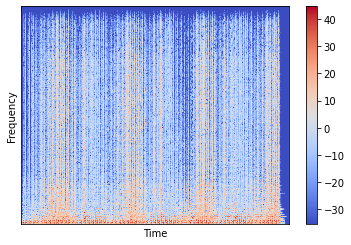

In [8]:
spectrogram = np.abs(stft)
db_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(db_spectrogram , sr = sr , hop_length = stride)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

## MFCC Generation
#### We generate the spectogram for the given waveform.We take the absolute values from the STFT. The vertical axis represents the frequency and the horizontal axis reprents time of the clip.
#### We convert the frequency axis to a logarithm as the highers values can be depicted properly and the computations also gets simpler.

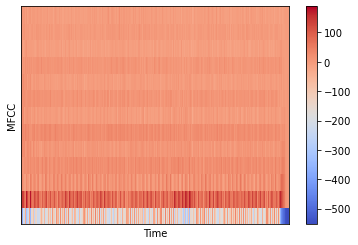

In [9]:
MFCCs = librosa.feature.mfcc(signal , n_fft = window_size , hop_length = stride , n_mfcc = 13)
librosa.display.specshow(MFCCs , sr = sr , hop_length = stride)
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

## Extracting MFCC
#### We define a function save_mfcc with the following parameters:
#### dataset_path - location of the dataset containing the audio files
#### json_path - location containing the JSON file into which our data will be stored
#### n_mfcc - number of coeffecients we want to extract from the spectrogram. Value generally lies between 12-20 but 13 provided us with the highest accuracy
#### n_fft - size of the window for feature generation and extraction
#### hop_length - stride length as to how many positions to shift when moving
#### num_segments - number of segments to generate from each audio track

### The main purpose of this function and its parameters is to take audio files as input, process them and extract the waveform from the said files. The waveforms are then converted to Spectrograms from which an MFCC spectrogram is generated. For each such spectrogram of a 30 second song, we create 10 smaller 3 second segments. Each of these segments are then stored as indivdual images, all while maintaining the same naming convention as the audio file. This data is then stored together, which goes on to become the new dataset for the CNN and RNN models used ahead.

In [10]:
import json
import os
import math
import librosa

dataset = 'D:/SRH Subjects/Sem 2/Technology Project 2/Data/genres_original'
j_path = './myjson.json'
sample_rate = 22050
duration = 30 
samples = sample_rate * duration

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=4084, hop_length=1024, num_segments=10):
    # creating a dictionary to store and easily label data
    dic_data = {
        'mapping' : [],
        'mfcc' : [],
        'labels' : []
    }
    
    tracker = 0 # To keep track of our progress
    segment_samples = int(samples / num_segments) # number of samples per segment
    segment_vectors = math.ceil(segment_samples / hop_length) # number of MFCC vectors per segment
    
    #Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        #ensure that we're not at the root level
        if dirpath not in dataset_path:

            #save the semantic label
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            dic_data['mapping'].append(semantic_label)
            print('\nProcessing {}'.format(semantic_label))
            
            #process files for a specific genre 
            for f in filenames:
                if f.endswith('.wav') and f != 'jazz.00054.wav': # Since file jazz.00054.wav is an empty file
                    
                    file_path = os.path.join(dirpath,f)
                    
                    #loading the audio file 
                    # we are using the soundfile library since it is faster than librosa
                    signal, sr = sf.read(file_path) # len(signal) = 661794  # sr is 22050 by default 
                    #print(signal,sr)
                    #process segments extracting mfcc and storing data
                    for s in range(num_segments): 
                        # Since num_segments is defined as 5. Every 30 sec file is divided into 5 segments of length 6sec 
                        # Start sample would keep track of the index of the first element of each 6 second batch
                        # finish sample would keep track of the index of the last element of each 6 second batch
                        # And then with the help of python's slice functionality we will extract that 6 second batch from every 30 sec signal
                        start_sample = segment_samples * s   
                        finish_sample = segment_samples + start_sample
                        
                        # Next, we will pass each segment in order to extract MFCC. The parameter n_mfcc defines the number of mfcc 
                        # we need to extract, Usually n_mfcc is set b/w 13 to 40. The other parameters n_fft and hop length are 
                        # indivisual topics of discussion. Will be discussed in later Notbooks. 
                        mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample],
                                                   sr = sr,
                                                   n_fft = n_fft,
                                                   n_mfcc = n_mfcc,
                                                   hop_length = hop_length)

                        mfcc = mfcc.T
                        
                        # store mfcc for segment if it has the expected length
                        if len(mfcc) == segment_vectors:
                            print(mfcc.shape)
                            dic_data['mfcc'].append(mfcc.tolist())
                            dic_data['labels'].append(i)
                            print('Processing {}, segment:{}'.format(file_path, s))
                            tracker += 1
                            print(tracker)
    with open(json_path, 'w') as fp:
        json.dump(dic_data, fp, indent=4)

In [11]:
# calling the function 
save_mfcc(dataset, j_path, num_segments=10)

2/Technology Project 2/Data/genres_original\rock\rock.00083.wav, segment:3
9823
(65, 13)
Processing D:/SRH Subjects/Sem 2/Technology Project 2/Data/genres_original\rock\rock.00083.wav, segment:4
9824
(65, 13)
Processing D:/SRH Subjects/Sem 2/Technology Project 2/Data/genres_original\rock\rock.00083.wav, segment:5
9825
(65, 13)
Processing D:/SRH Subjects/Sem 2/Technology Project 2/Data/genres_original\rock\rock.00083.wav, segment:6
9826
(65, 13)
Processing D:/SRH Subjects/Sem 2/Technology Project 2/Data/genres_original\rock\rock.00083.wav, segment:7
9827
(65, 13)
Processing D:/SRH Subjects/Sem 2/Technology Project 2/Data/genres_original\rock\rock.00083.wav, segment:8
9828
(65, 13)
Processing D:/SRH Subjects/Sem 2/Technology Project 2/Data/genres_original\rock\rock.00083.wav, segment:9
9829
(65, 13)
Processing D:/SRH Subjects/Sem 2/Technology Project 2/Data/genres_original\rock\rock.00084.wav, segment:0
9830
(65, 13)
Processing D:/SRH Subjects/Sem 2/Technology Project 2/Data/genres_origi

## CNN
### Since we would be working with image recognition from here on and the main objective would be pattern recognition across spatial data rather than temporal data, we found CNN to be a better fit than RNN for our project

In [12]:
import json
import numpy as np

#### We load the data from the JSON file into our dictionary to easily segregate the data into our dependent (y) and independent (X) variables.

In [13]:
DATA_PATH = "./myjson.json"

def load_dataset(data_path):
    
    with open(data_path,"r") as fp:
        dic_data = json.load(fp)
        
    X = np.array(dic_data["mfcc"])
    y = np.array(dic_data["labels"])
    return X , y  

### We use sklearn to split split our dataset into training, validation and testing data for the CNN

In [14]:
from sklearn.model_selection import train_test_split

def prepare_datasets(test_size,val_size):
    
    X , y = load_dataset(DATA_PATH)
    X_train,X_test,y_train,y_test = train_test_split(X , y , test_size = test_size)
    X_train,X_validation,y_train,y_validation = train_test_split(X_train , y_train , test_size = val_size)
    
    # np.newaxis is used to increase the dimensions by an axis or more.
    # So when we use np.newaxis once, it will transform 2d-(130,13) to 3d-(130,13,1) 
    X_train = X_train[...,np.newaxis]
    X_validation = X_validation[...,np.newaxis] 
    X_test = X_test[...,np.newaxis]
    
    return X_train,X_validation,X_test,y_train,y_validation,y_test 

### We take 25% of the data for testing and 20% for validation

In [15]:
X_train,X_validation,X_test,y_train,y_validation,y_test = prepare_datasets(0.25,0.2)

### ReLU activation function essentially checks the individual values assigned to each pixel by the CNN. If the value assigned is positive the function will let it be as is. If the value is negative then ReLU will convert the pixel value to zero and proceed to the next pixel

In [16]:
import tensorflow.keras as keras


def build_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32 , (3,3) ,activation = 'relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(64 , (3,3) ,activation = 'relu'))
    model.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(120 , (2,2) ,activation = 'relu'))
    model.add(keras.layers.MaxPooling2D((2,2),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64,activation = 'relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(11,activation='softmax'))
    
    return model

### Setting a specific learning rate for the Gradient Descent Approach so as to arrive at the local minimum and aid with backpropagation. This will basically view and act on the error term and adjust the features again to improve the accuracy of the model

In [17]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
model = build_model(input_shape)
optimizer =  keras.optimizers.Adam(learning_rate=0.001) 
model.compile(optimizer = optimizer ,loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
model.fit(X_train,y_train,validation_data = (X_validation,y_validation),batch_size=32,epochs=30)

Epoch 1/30
188/188 [==============================] - 10s 40ms/step - loss: 1.6745 - accuracy: 0.4394 - val_loss: 1.6054 - val_accuracy: 0.4330
Epoch 2/30
188/188 [==============================] - 5s 27ms/step - loss: 1.2057 - accuracy: 0.5839 - val_loss: 1.2643 - val_accuracy: 0.5570
Epoch 3/30
188/188 [==============================] - 4s 19ms/step - loss: 0.9869 - accuracy: 0.6539 - val_loss: 1.0161 - val_accuracy: 0.6478
Epoch 4/30
188/188 [==============================] - 4s 19ms/step - loss: 0.8223 - accuracy: 0.7128 - val_loss: 0.8756 - val_accuracy: 0.7038
Epoch 5/30
188/188 [==============================] - 4s 19ms/step - loss: 0.7287 - accuracy: 0.7513 - val_loss: 0.9748 - val_accuracy: 0.6838
Epoch 6/30
188/188 [==============================] - 4s 19ms/step - loss: 0.6416 - accuracy: 0.7772 - val_loss: 0.8356 - val_accuracy: 0.7312
Epoch 7/30
188/188 [==============================] - 4s 19ms/step - loss: 0.5953 - accuracy: 0.7924 - val_loss: 1.0941 - val_accuracy: 0.675

In [19]:
test_error , test_accuracy = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy on test is {}".format(test_accuracy))
print("Test error is {}".format(test_error))

79/79 [==============================] - 1s 12ms/step - loss: 1.0635 - accuracy: 0.7602
Accuracy on test is 0.7602081894874573
Test error is 1.0635324716567993


In [20]:
def predict(model , X , y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction , axis = 1)
    print("Expected index : {} predicted index : {}".format(y,predicted_index[0]))

In [21]:
X = X_test[100]
y = y_test[100]
predict(model , X , y)

Expected index : 3 predicted index : 3
